In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('market-price.csv', header=None);df

,0,1
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000
...,...,...
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231


In [7]:
df.rename(columns={0:'date', 1:'price'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [8]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   price   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [10]:
df.set_index('date', inplace=True)

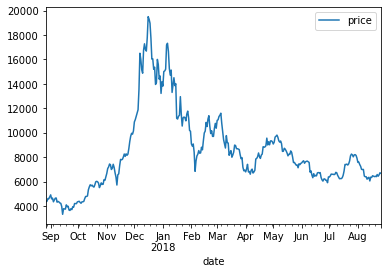

In [11]:
df.plot()
plt.show()

In [27]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [28]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
import pmdarima as pm

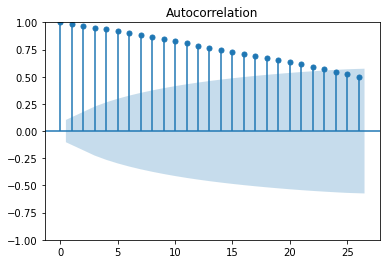

In [19]:

plot_acf(df)
plt.show()
#  선형적으로 느리게 감소하는 걸로 보아 확률적 추세를 가짐을 예측할 수 있다.

c:\Users\kgt08\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


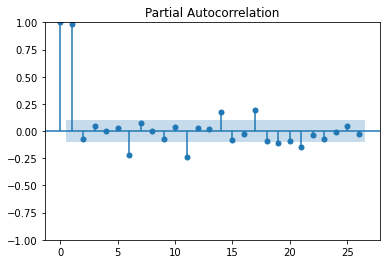

In [20]:
plot_pacf(df)
plt.show()
# 1시점 이후로 백색잡음에서의 형태를 띄므로 ARIMA(1, 1, 0) 모델을 잠정모형으로 선택한다.

KeyError: 'date'

In [32]:
kpss_diffs = ndiffs(df, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [34]:
model = pm.auto_arima(y = df        # 데이터
    , d = 1            # 차분 차수, ndiffs 결과!
    , start_p = 0 
    , max_p = 3   
    , start_q = 0 
    , max_q = 3   
    , m = 1       
    , seasonal = False # 계절성 ARIMA가 아니라면 필수!
    , stepwise = True
    , trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5583.718, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5584.063, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5583.897, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5581.775, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5583.265, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.306 seconds


In [35]:
model = pm.auto_arima(df, d = 1, seasonal = False, trace = True)
model.fit(df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5586.967, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5583.718, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5584.063, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5583.897, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5581.775, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5583.265, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.710 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [43]:
df_1 = df.diff(periods = 1).iloc[1:]

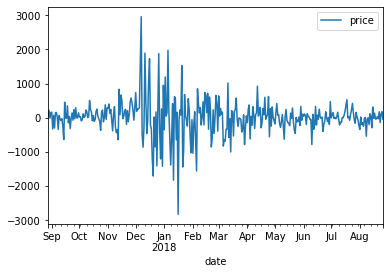

In [45]:
df_1.plot()
plt.show()

c:\Users\kgt08\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


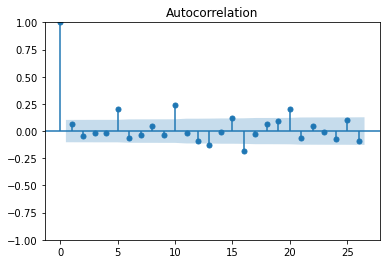

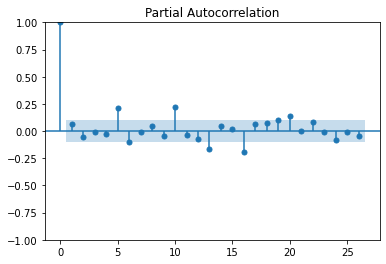

In [46]:
plot_acf(df_1)
plot_pacf(df_1)
plt.show()

In [47]:
print(model.summary())
# Ljung-Box 검정 결과 p-value가 0.05보다 크므로 유의수준 5%에서 귀무가설을 기각해 백색잡음으로 판단할 수 있다.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2789.887
Date:                Tue, 08 Nov 2022   AIC                           5581.775
Time:                        19:05:28   BIC                           5585.672
Sample:                    08-27-2017   HQIC                          5583.324
                         - 08-26-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.652e+05   8989.834     29.506      0.000    2.48e+05    2.83e+05
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):               856.48
Prob(Q):                              0.20   Pr

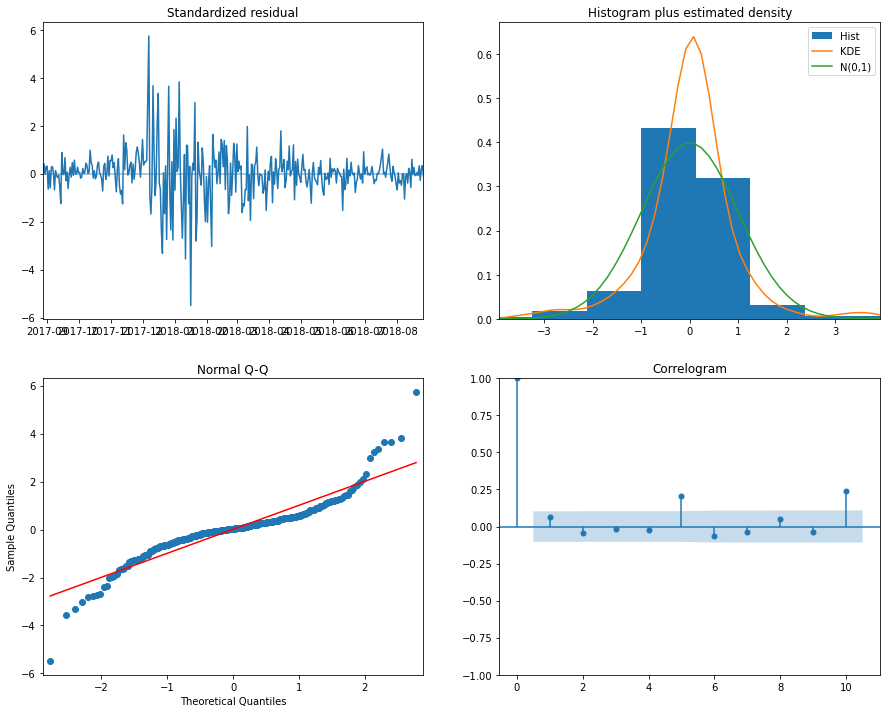

In [48]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

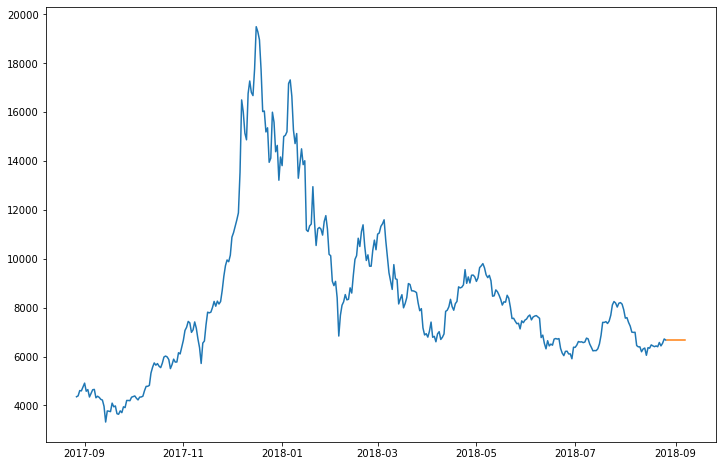

In [67]:
y_predict = model.predict(n_periods = 12)
plt.figure(figsize = (12, 8))
plt.plot(df)
plt.plot(y_predict)
plt.show()

In [50]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [57]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in df_1.values:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  729
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5764.220
Date:                Tue, 08 Nov 2022   AIC                          11530.439
Time:                        19:17:26   BIC                          11535.029
Sample:                             0   HQIC                         11532.210
                                - 729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.438e+05   7487.009     59.280      0.000    4.29e+05    4.59e+05
===================================================================================
Ljung-Box (L1) (Q):                  38.37   Jarque-Bera (JB):              9511.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -1.46
Prob(H) (two-sided):                  0.01   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
model.forecast(12)

AttributeError: 'ARIMA' object has no attribute 'forecast'

In [65]:
model.fit(df).forecast(12)

AttributeError: 'ARIMA' object has no attribute 'forecast'